In [231]:
import time
import random
import numpy as np
import pulp as plp
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

In [232]:
from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    
    start_time = time.time()
    status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
    solveTime.append(time.time() - start_time) 

    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue    
                    
    return float(opt_model.objective.value()), varsdict

In [233]:
def Prepare_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

In [234]:
def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("black")
        else:
            node_colors.append("silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

In [235]:
def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

In [236]:
def create_data(n):
    
    k = 0.5
    
    #G = nx.triangular_lattice_graph(n,n)
    G = nx.grid_2d_graph(n,n)
    #G = nx.path_graph(n)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    G = Add_Weights(G,1.0)
    
    
    matrix = nx.to_numpy_matrix(G)
    g, weights, signed_matrix = Prepare_Data([matrix])

    fi,vr = Model(weights, signed_matrix)
    #frustrations.append(fi)
    G = color_nodes(G,vr)
    
    pos = nx.spring_layout(G, weight=None)
    nx.set_node_attributes(G,pos,'pos')
    

    return G

In [9]:
G0 = create_data(5)

<IPython.core.display.Javascript object>


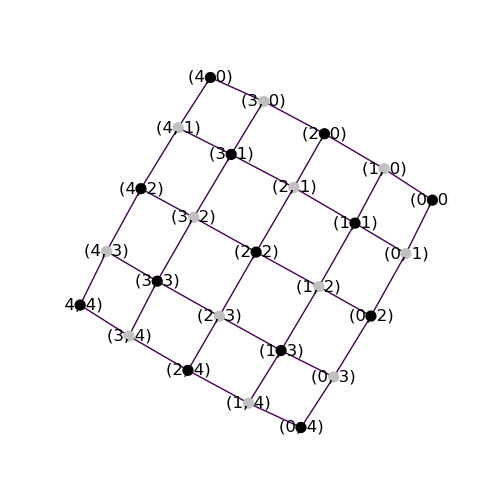

In [10]:
G = G0

pos = nx.spring_layout(G, weight=None)
node_colors=nx.get_node_attributes(G,'color')
edge_colors=nx.get_edge_attributes(G,'weight')

#print(edge_colors)

fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)
#Properties(G)

#print("f =",frustration_count(G))

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Simulated Annealing

In [237]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [238]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

In [239]:
import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    """Peforms simulated annealing to find a solution"""
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

In [240]:
def Plot2D(G):

    pos =nx.get_node_attributes(G,'pos')
    node_colors=nx.get_node_attributes(G,'color')
    edge_colors=nx.get_edge_attributes(G,'edge_color')

    fig, ax = plt.subplots(figsize=(2,2))
    nx.draw(G,pos,node_size=50,edge_color="red",node_color=node_colors.values(),with_labels=False)

21.0
40
d0 = 0


<IPython.core.display.Javascript object>


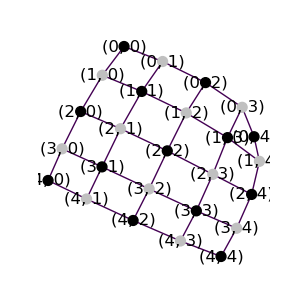

<IPython.core.display.Javascript object>


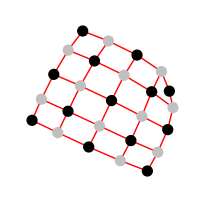

df = 21


<IPython.core.display.Javascript object>


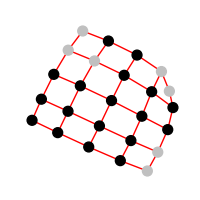

In [241]:
#F = FG(3,0.5)


F = create_data(5)

d_target = int(len(F.edges()))/2+1

print(d_target)

print(len(F.edges()))
d0 = calculate_delta(F)
print("d0 =",d0)

G = F

pos =nx.get_node_attributes(G,'pos')
node_colors=nx.get_node_attributes(G,'color')
edge_colors=nx.get_edge_attributes(G,'weight')


fig, ax = plt.subplots(figsize=(3,3))
nx.draw(G,pos,node_size=50,edge_color=edge_colors.values(),node_color=node_colors.values(),with_labels=True)

Plot2D(F)


H = simulated_annealing(F,target=d_target)
df = calculate_delta(H)
print("df =",df)

Plot2D(H)

In [92]:
from scipy.stats import sem

def Calculate_Probabilites(size,target):
    probabilites = []
    edges = []
    AVG = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(100)):

            F = create_data(size)
            
            H = simulated_annealing(F.copy(),target=d_target)

            edge = len(H.copy().edges())
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,edge):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)
        AVG.append(avg)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/100,np.std(total[:,i])/100))

    return np.array(final)

In [93]:
probabilites=Calculate_Probabilites(5,target)
values = probabilites[:,0]
errors = probabilites[:,1]

100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


<IPython.core.display.Javascript object>


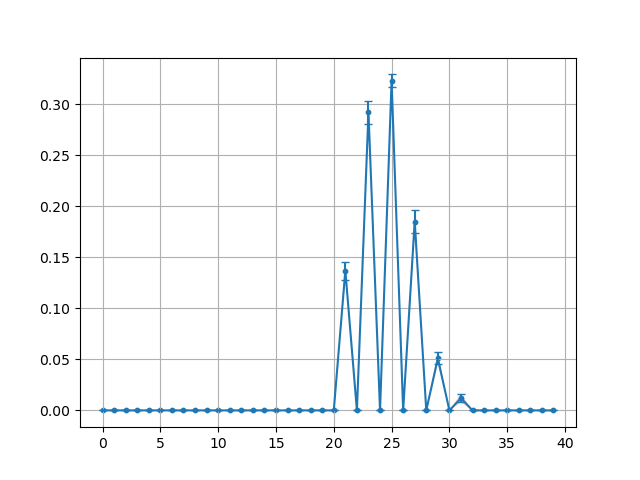

In [94]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()
#ax.set_xlim(50,125)

# Mean Value Evolution

In [98]:
from tqdm.notebook import tqdm

def new_Quench(G0):#,var,fi):
    

    p=0.0
    total=[]
    start = time.time()
    ####################################################################################
    for i in tqdm(range(500)):
        
        H = G0.copy()
        res=[]
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            #H = color_nodes(H,var)
            
            fr = frustration_count(H)
            res.append(fr)
            

        total.append(res)
    ####################################################################################        
    end = time.time()
    print("completed",end - start)
    
    total = np.array(total)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))
        
        
    return final,total

In [99]:
results, total = new_Quench(G0)#,var,fi)


completed 54.42475605010986


<IPython.core.display.Javascript object>


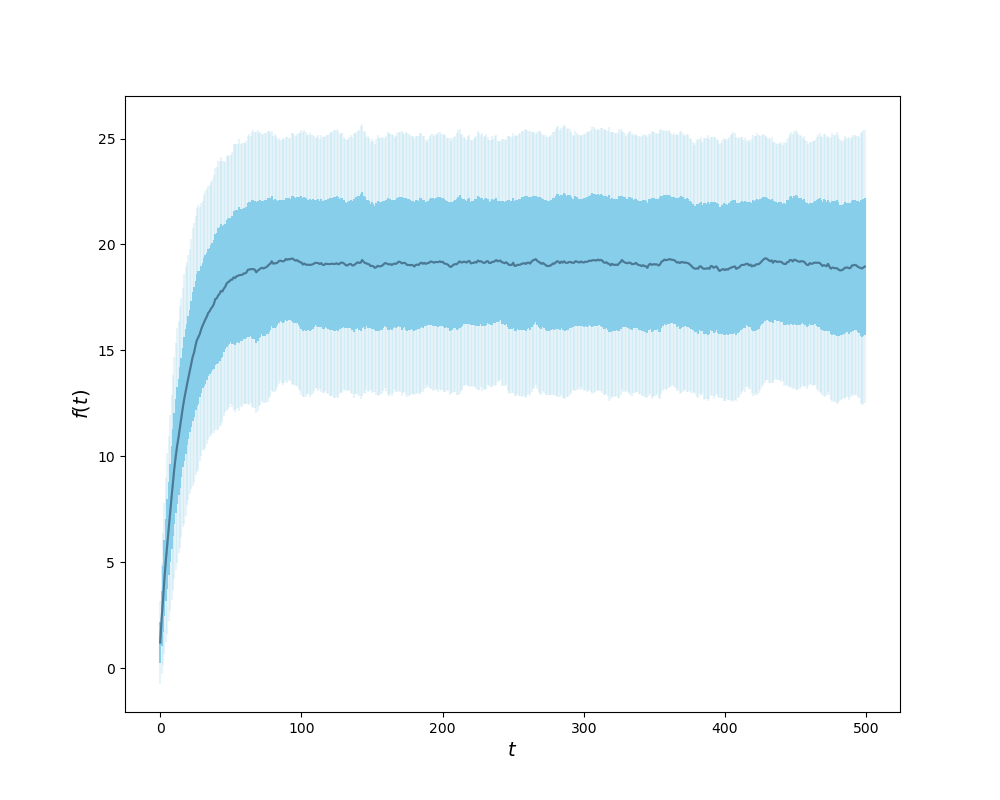

In [100]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[z for y,z in results],ecolor="skyblue")
ax.errorbar([x for x in range(len(results))],[y for y,z in results],[2*z for y,z in results],ecolor="skyblue",alpha=0.2)

#ax.set_xlabel('$x$', fontsize=14)
#ax.set_ylabel('$f(x)$', fontsize=14)

ax.set_xlabel('$t$', fontsize=14)
ax.set_ylabel('$f(t)$', fontsize=14)
plt.show()

# Evolution

In [117]:
from tqdm.notebook import tqdm

def Quench2(G0):#,var,fi):
    

    p=0.0
    total=[]
    start = time.time()
    probabilites = []
    ####################################################################################
    for i in tqdm(range(500)):
        
        H = G0.copy()
        res=[]
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            #H = color_nodes(H,var)
            
            fr = frustration_count(H)
            res.append(fr)
            
        prob=[]
        for i in range(0,edge):
            prob.append(np.count_nonzero(np.array(res) == i))
        probabilites.append(prob)

        total.append(res)
    ####################################################################################        
    end = time.time()
    print("completed",end - start)
    
    total = np.array(total)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))
    
    """
    probabilites = np.array(probabilites)
    probs = []
    for i in range(0,len(probabilites[0])):
        probs.append((np.mean(probabilites[:,i])/500,np.std(probabilites[:,i])/500))
    """
        
    return final,probabilites

In [118]:
G0 = create_data(5)

In [119]:
means, probs = Quench2(G0)


completed 56.267425298690796


In [170]:
probs_ = []
for ps in probs:
    probs_.append(np.array(ps)/500)

<IPython.core.display.Javascript object>


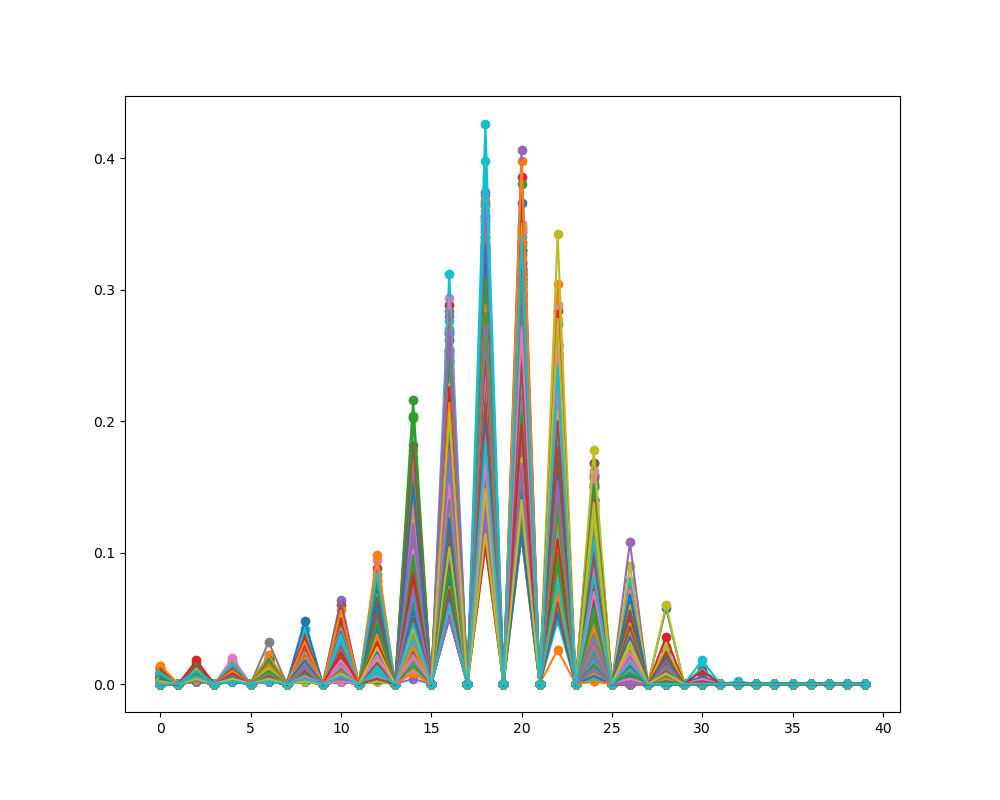

In [126]:
fig, ax = plt.subplots(figsize=[10,8])

for ps in probs:
    ax.scatter([i for i in range(len(ps))],np.array(ps)/500)
    ax.plot([i for i in range(len(ps))],np.array(ps)/500)

plt.show()

<IPython.core.display.Javascript object>


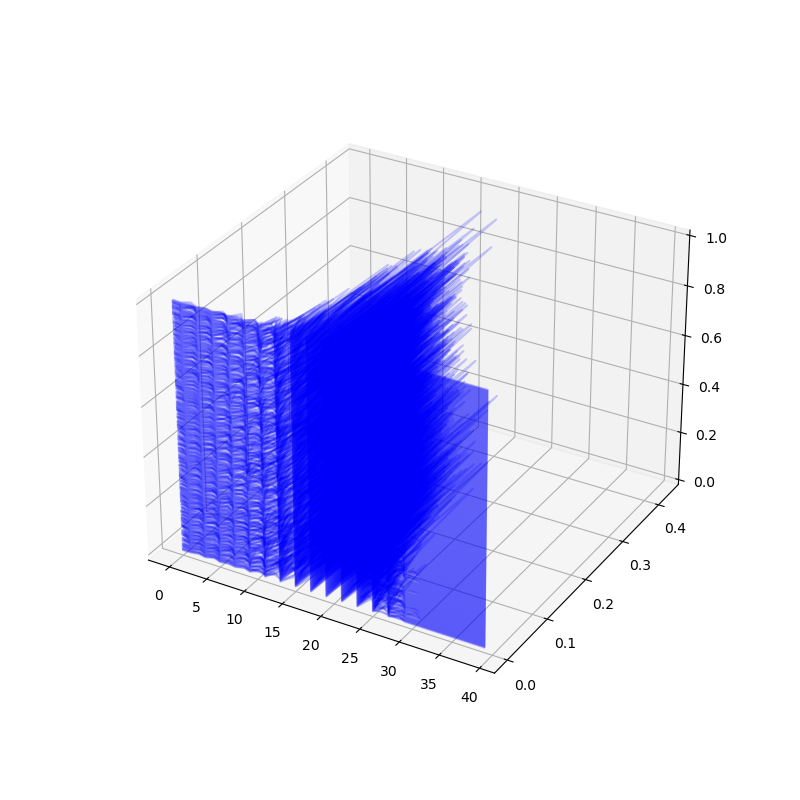

In [177]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')

for index,ps in enumerate(probs):
    #ax.scatter([i for i in range(len(ps))],np.array(ps)/500)
    ax.plot([i for i in range(len(ps))],np.array(ps)/500,np.linspace(0,1,500)[index],color="blue",alpha=0.2)

plt.show()

<IPython.core.display.Javascript object>


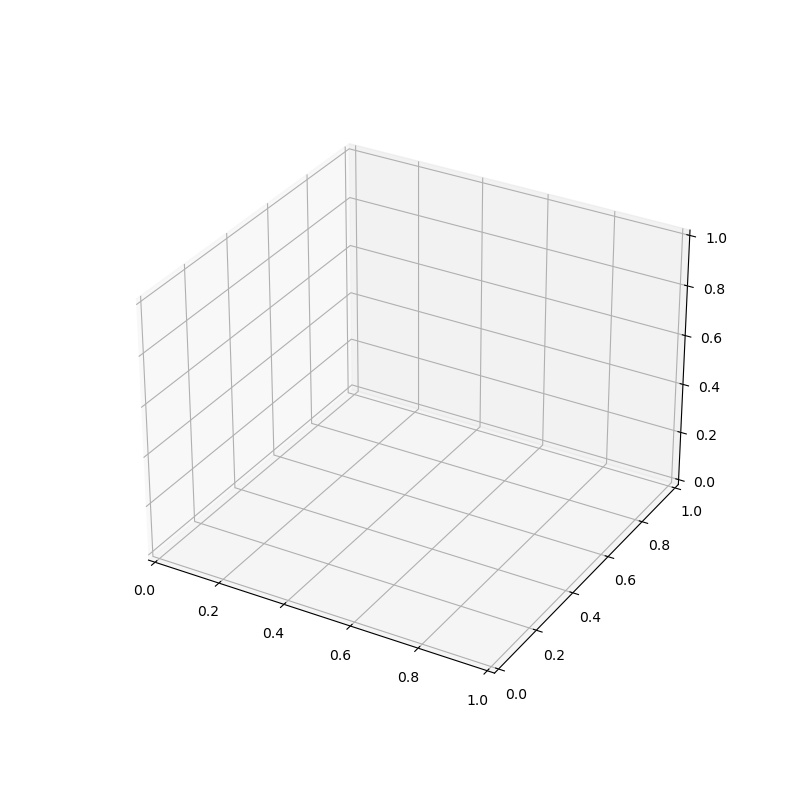

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [171]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')

for j in range(len(probs_)):
    #ax.plot([i for i in range(len(avg[j][:,0]))],avg[j][:,0],j, label='parametric curve')
    ax.plot(probs_[j][:,0],[i for i in range(len(probs_[j][:,0]))],np.linspace(0,1)[j], label='parametric curve',c="blue",alpha=0.4)

    ax.view_init(azim=0, elev=-20)

ax.set_xlabel('Probability $P(f)$')
ax.set_ylabel('Frustration $f$')
ax.set_zlabel('Index $k$')
plt.show()

In [128]:
fig, ax = plt.subplots()

for p in P_at_t:
    ax.plot([i for i in range(len(p))],p)#,s=10)#,marker="x")

fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')

for j in range(len(P_at_t)+10-len(P_at_t)):
    ax.plot([i for i in range(len(P_at_t[j]))],P_at_t[j],j*10,color="blue",alpha=0.3)   

(500, 40)

# 3D plot

In [130]:
# http://www.rpgroup.caltech.edu/ibdm_cbbtn/programming

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import glob
import skimage.io
import skimage.measure
import skimage.filters

def bar_plot (data, n_slices, dx = 1, dy = 1, z_max = 1, x_label = 'x',
              y_label='y', z_label='z', elev_angle = 30, azim_angle = 115):
    """
    Makes a 3d bar plot of the data given as a 2d numpy array.

    Parameters
    ----------
    data: 2d-array
        Two-dimensional numpy array of z-values
    n_slices: int
        Number of 'slices' in y-directions to be used in the 3D plot
    dx: float
        Distance between neighboring x-positions
    dy: float
        Distance between neighboring y-positions
    x_label: str
        Label of the x-axis
    y_label: str
        Label of the y-axis
    z_lable: str
        Label of the z-axis
    elev_angle: int
        Alevation viewing angle
    azim_angle: int
        Azimuthal viewing angle
    z_max: float
        Default limit to the z-axis

    Returns
    -------
    fig: pyplot figure object
        Figure of the 3d-plot

    ax: pyplot axes object
        Axes object that contains the figure elements
    """

    # Initialize the figure object
    fig = plt.figure(figsize = [10, 8])
    ax = fig.add_subplot(111, projection='3d')

    # Colors to indicate variation in y-axis
    colors = sns.color_palette('YlGnBu_r', n_colors=n_slices+1)

    # Dimensions of the 2d-array
    x_length, y_length = data.shape

    # Initial index of the slice
    i_slice = 0

    # Iterate through each slice and add bar plots
    for y in np.arange(0, y_length, y_length//n_slices):

        # x-, y- and z-positions
        x_pos = np.arange(x_length)*dx
        y_pos = y*np.ones(x_length)*dy
        z_pos = np.zeros(x_length)

        # Horizontal dimensions of the bars
        delta_x = dx*np.ones(x_length)
        delta_y = 2*dy*np.ones(x_length)

        # Heights in the z-direction
        delta_z = data[:,y]

        ax.bar3d(x_pos, y_pos, z_pos, delta_x, delta_y, delta_z,
                 color = colors[i_slice], edgecolor='none')

        i_slice = i_slice + 1;

    # Add axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

    # Adjust the 3d viewing angle of the plot
    ax.view_init(elev_angle, azim_angle)

    # Set the z-limit of the plot
    z_max = np.min([z_max, np.max(data)])
    ax.set_zlim([0, z_max])

    return fig, ax


def create_mask (phase_image, gauss_radius = 50, threshold = -0.2, \
                 pixel_size = 0.16, area_low = 1, area_high = 5):

    # Normalize
    im_float = (phase_image - np.min(phase_image))/(np.max(phase_image)-np.min(phase_image))

    # Find the background
    im_bg = skimage.filters.gaussian(im_float, gauss_radius)

    # Subtract the background
    im_gauss = im_float - im_bg

    # Threshold the image
    im_thresh = im_gauss < threshold

    # Label the image
    im_label = skimage.measure.label(im_thresh)

    # Obtain the features of the objects
    props = skimage.measure.regionprops(im_label)

    # Remove small objects
    im_mask = np.zeros_like(im_label)
    for prop in props:
        area = prop.area * pixel_size**2
        if (area > area_low) and (area < area_high):
            im_mask = im_mask + (im_label == prop.label)

    # Label the mask
    im_mask_label = skimage.measure.label(im_mask)

    # Return the labeled mask
    return im_mask_label


def find_intensities (im_yfp, im_mask_label):

    # List to store the object intensity values
    intensities = []

    # Obtain the features of objects in the YFP channel
    props = skimage.measure.regionprops(im_mask_label, intensity_image=im_yfp)

    # Add the YFP intensity values
    for prop in props:
        intensities.append(prop.mean_intensity)

    return intensities


def find_intensities_all (operator, repressor):
    # Array to store intensity values from all the strains
    intensities_all = []

    # Filename structure
    file_structure_phase = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'phase*'
    file_structure_yfp = 'data/lacI_titration/' + operator + '_' + repressor + '_' + 'yfp*'

    # Name of all images for a given strain
    phase_names = glob.glob(file_structure_phase)
    yfp_names = glob.glob(file_structure_yfp)

    # Number of positions
    n_positions = len(phase_names)

    for i in range(n_positions):
        im_phase = skimage.io.imread(phase_names[i])
        im_yfp = skimage.io.imread(yfp_names[i])

        im_mask_label = create_mask(im_phase)
        intensities = find_intensities(im_yfp, im_mask_label)

        for intensity in intensities:
            intensities_all.append(intensity)

    return intensities_all

In [140]:
np.shape(probs)

(500, 40)

In [152]:
len(probs[0])

40

In [159]:
Probs=[]
for i in range(len(probs[0])):
    Probs.append(np.array(probs)[:,i]/500)

PROBS = np.array(Probs)

In [160]:
np.shape(Probs)

(40, 500)

<IPython.core.display.Javascript object>


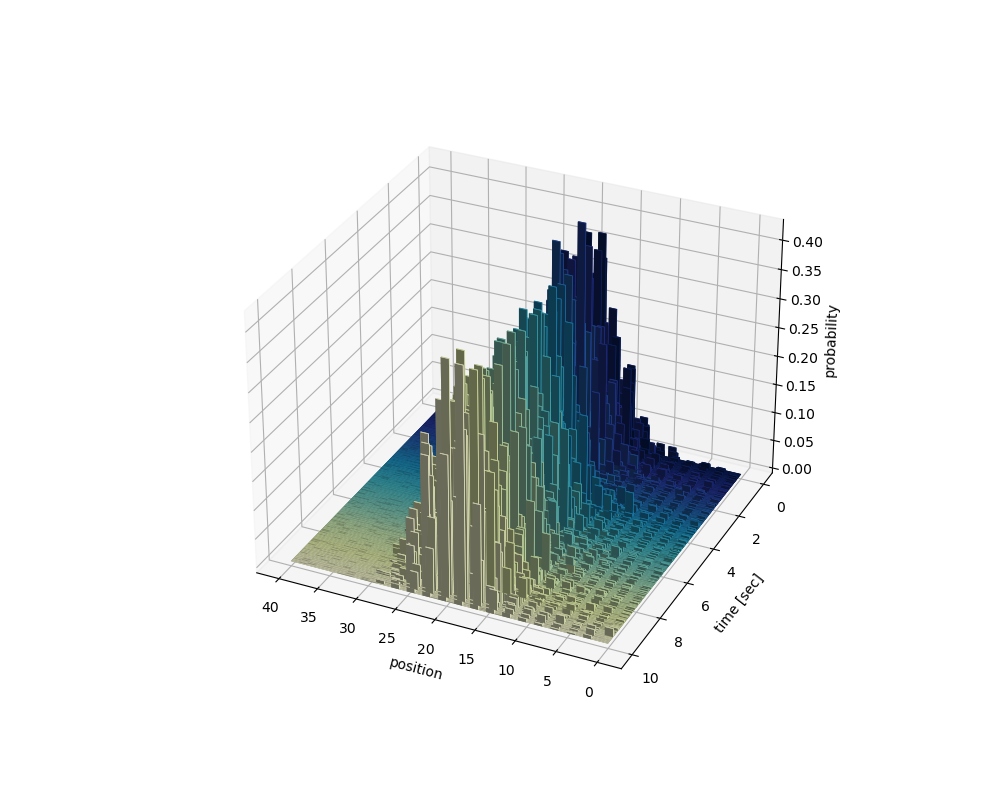

In [167]:
%matplotlib notebook

# Generate the 3D bar plot. 
bar_plot(PROBS, 500, dx=1, dy=0.02, x_label='position', 
            y_label='time [sec]', z_label='probability')
plt.show()

# continuation checking probability calculation

In [242]:
from tqdm.notebook import tqdm

def KVUNČ(G0):#,var,fi):
    

    total=[]
    ####################################################################################
    for i in tqdm(range(100)):
        
        H = G0.copy()
        res=[]
        for k in range(0,500):
            
            H = nx.algorithms.double_edge_swap(H, nswap=1)
            H = Add_Weights(H,1.0)
            #H = color_nodes(H,var)
            
            fr = frustration_count(H)
            res.append(fr)

        total.append(res)
    ####################################################################################        
        
    return total

In [243]:
G0 = create_data(5)

In [244]:
mean = KVUNČ(G0)

In [245]:
means = np.array(mean)

In [246]:
len(means[0])

500

In [248]:
G0 = create_data(5)

edge = len(G0.copy().edges())

print(edge)

p_t=[]
for t in range(len(means[0])):

    #print(means[:,t])
    
    prob=[]
    for i in range(0,edge):
        prob.append(np.count_nonzero(np.array(means[:,t]) == i))
    p_t.append(np.array(prob)/100)


40


In [249]:
p_t[0]

array([0.4, 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. ])

In [250]:
P_t = np.array(p_t)

<IPython.core.display.Javascript object>


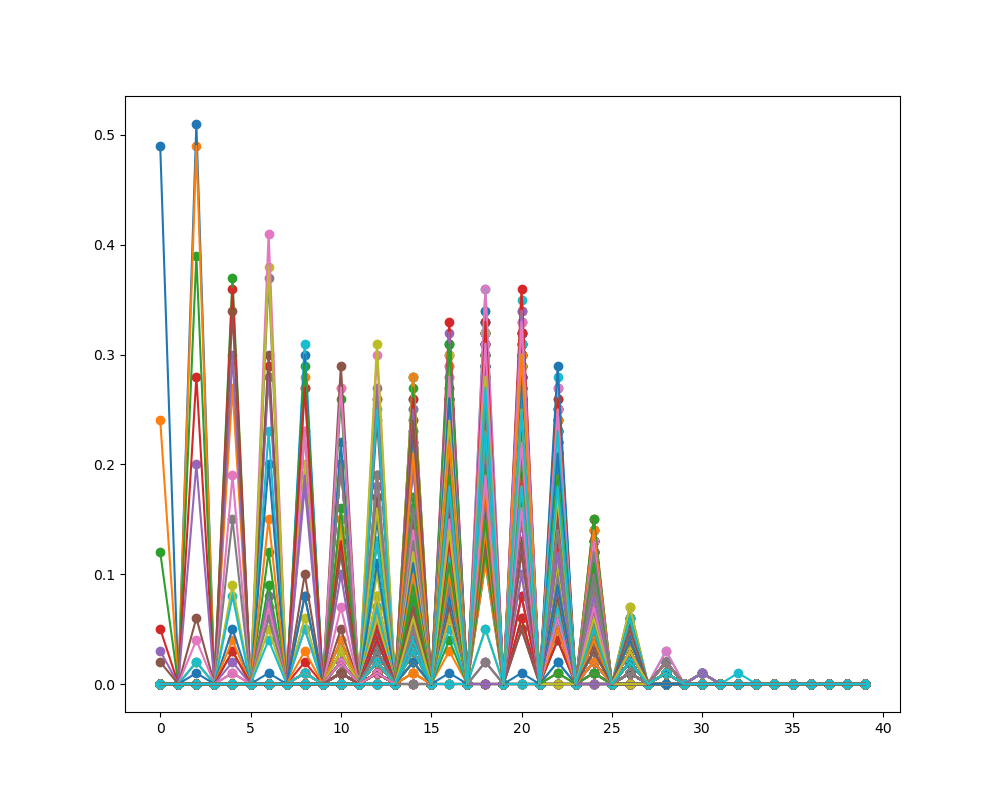

In [200]:
fig, ax = plt.subplots(figsize=[10,8])

for ps in p_t:
    ax.scatter([i for i in range(len(ps))],ps)
    ax.plot([i for i in range(len(ps))],ps)

plt.show()

<IPython.core.display.Javascript object>


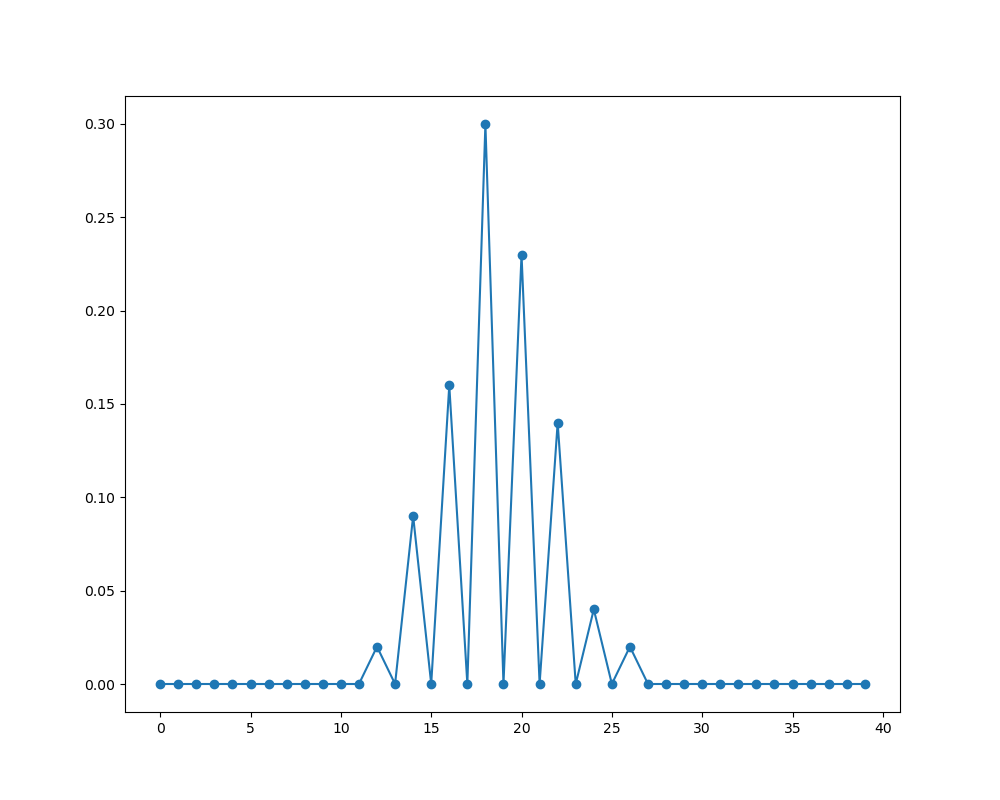

In [207]:
fig, ax = plt.subplots(figsize=[10,8])

time = 250

ax.scatter([i for i in range(len(P_t[time]))],P_t[time])
ax.plot([i for i in range(len(P_t[time]))],P_t[time])

plt.show()

# Slider

<IPython.core.display.Javascript object>


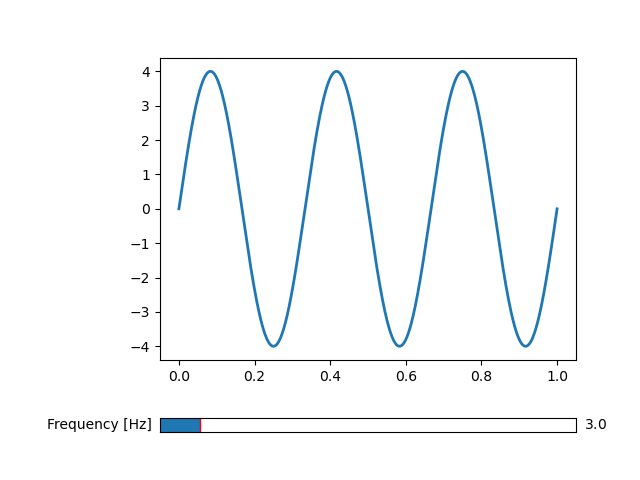

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, frequency):
    return 4 * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_frequency), lw=2)


# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)

plt.show()

<IPython.core.display.Javascript object>


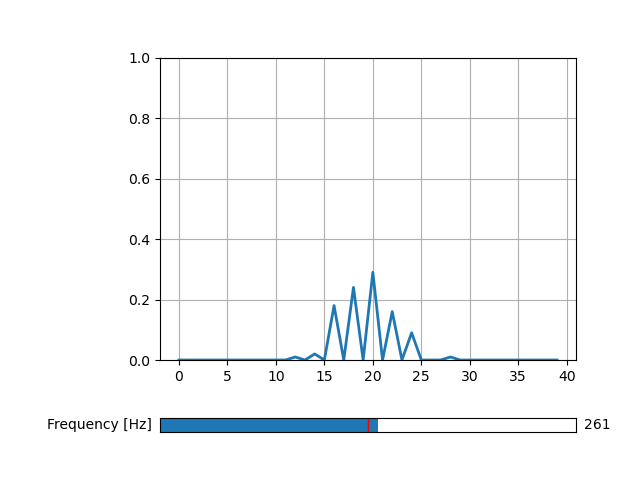

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


#def f(t, frequency):
    #return 4 * np.sin(2 * np.pi * frequency * t)

def f(t,P_t):
    return P_t[t]

def update(val):
    line.set_ydata(f(int(freq_slider.val), P_t))
    fig.canvas.draw_idle()

    
t = 250

#init_frequency = 250

fig, ax = plt.subplots()
line, = plt.plot([i for i in range(len(P_t[t]))], f(t, P_t), lw=2)

ax.set_ylim(0,1)
plt.grid()

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])


freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valmax=499,
    valfmt = "%d",
    valinit=t,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

freq_slider.on_changed(update)
plt.show()

# without spikes

In [255]:
l = list(range(10))

print(l[::2])  

[0, 2, 4, 6, 8]


In [259]:
p_even=[]
for l in P_t:
    p_even.append(l[::2])
    
P_even = np.array(p_even)

P_even

array([[0.4 , 0.6 , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.15, 0.52, 0.33, ..., 0.  , 0.  , 0.  ],
       [0.05, 0.38, 0.39, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

<IPython.core.display.Javascript object>


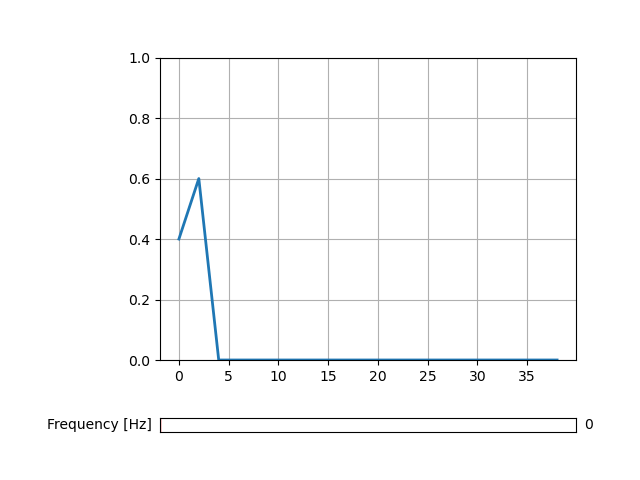

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


#def f(t, frequency):
    #return 4 * np.sin(2 * np.pi * frequency * t)

def f(t,array):
    return array[t]

def update(val):
    line.set_ydata(f(int(freq_slider.val), P_even))
    fig.canvas.draw_idle()

    
t = 0

#init_frequency = 250

fig, ax = plt.subplots()
line, = plt.plot([i*2 for i in range(len(P_even[t]))], f(t, P_even), lw=2)

ax.set_ylim(0,1)
plt.grid()

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])


freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valmax=500/2-1,
    valfmt = "%d",
    valinit=t,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

freq_slider.on_changed(update)
plt.show()

In [262]:
[i for i in range(len(P_even[t]))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# Larger Graph

In [265]:
G0 = create_data(10)

In [268]:
data = np.array(KVUNČ(G0))

In [269]:
G0 = create_data(10)

edge = len(G0.copy().edges())

print(edge)

p_t=[]
for t in range(len(data[0])):

    #print(means[:,t])
    
    prob=[]
    for i in range(0,edge):
        prob.append(np.count_nonzero(np.array(data[:,t]) == i))
    p_t.append(np.array(prob)/100)


180


In [270]:
p_even=[]
for l in np.array(p_t):
    p_even.append(l[::2])
    
P_even = np.array(p_even)

P_even

array([[0.51, 0.49, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.32, 0.41, 0.27, ..., 0.  , 0.  , 0.  ],
       [0.13, 0.38, 0.33, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

<IPython.core.display.Javascript object>


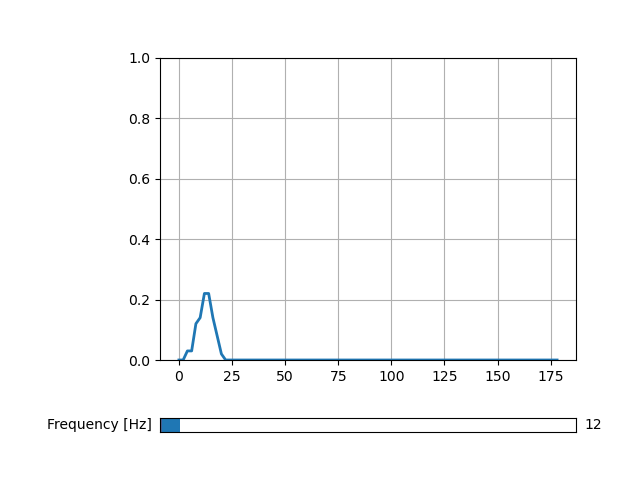

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


#def f(t, frequency):
    #return 4 * np.sin(2 * np.pi * frequency * t)

def f(t,array):
    return array[t]

def update(val):
    line.set_ydata(f(int(freq_slider.val), P_even))
    fig.canvas.draw_idle()

    
t = 0

#init_frequency = 250

fig, ax = plt.subplots()
line, = plt.plot([i*2 for i in range(len(P_even[t]))], f(t, P_even), lw=2)

ax.set_ylim(0,1)
plt.grid()

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])


freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valmax=500/2-1,
    valfmt = "%d",
    valinit=t,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

freq_slider.on_changed(update)
plt.show()

# Comparison to Theory

In [272]:
def master_equation3(prob, L,d, k1, k2, dt):

    num_boxes, time_points = np.shape(prob)
     
    for t in range(1, time_points): 

        prob[0, t] = prob[0, t-1] + k1(L,d,1) * dt * prob[1, t-1] - k2(L,d,0) * dt * prob[0, t-1]
       
        last_box = num_boxes - 1
        prob[last_box, t] = prob[last_box, t-1] + \
                                k1(L,d,last_box-1) * dt * prob[last_box-1, t-1] -\
                                k2(L,d,last_box) * dt * prob[last_box, t-1]
                
        for box in range(1, num_boxes - 1):
            prob[box, t] = prob[box, t-1] +\
                            k1(L,d,box-1) * dt * prob[box-1, t-1] +\
                            k2(L,d,box+1) * dt * prob[box+1, t-1] -\
                            (k1(L,d,box)+k2(L,d,box)) * dt * prob[box, t-1]
            
            if prob[box, t] > 1:
                print(box,t,prob[box, t])

            
    return prob

In [300]:
d = 0
L = 90

def k1(L,d,x):
    
    return (4*x**2 - d**2)/(2*L*(L-1))

def k2(L,d,x):
    
    return (4*x**2 + (1-2*L)*2*x + L*(L-1))/(2*L*(L-1))


dt = 1 / 50
num_boxes = L
time_steps = 500

import numpy as np

prob = np.zeros((num_boxes, time_steps))

print(np.shape(prob))

initial_position = 1#int(num_boxes/ 2) - 1


prob[initial_position, 0] = 1.0

print(prob)

prob = master_equation3(prob, L, d, k1 , k2, dt)

(90, 500)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<IPython.core.display.Javascript object>


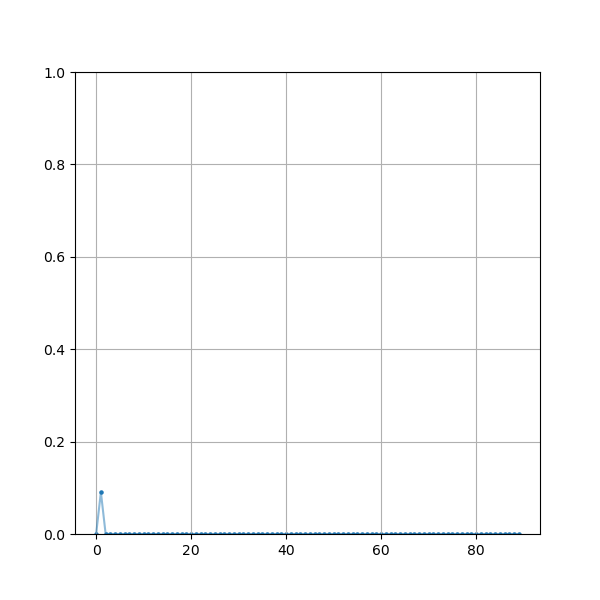

In [301]:
i= 250

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter([i for i in range(len(prob[:,i]))],prob[:,i],s=5)

ax.plot([i for i in range(len(prob[:,i]))],prob[:,i],alpha=0.5)


ax.set_ylim(0,1)
plt.grid()

plt.show()
    

In [285]:
print(np.shape(P_even))

(500, 90)


In [292]:
print(P_even)

[[0.51 0.49 0.   ... 0.   0.   0.  ]
 [0.32 0.41 0.27 ... 0.   0.   0.  ]
 [0.13 0.38 0.33 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [291]:
print(np.shape(prob))

(90, 500)


In [294]:
print(prob.T)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.99       0.         0.         ... 0.         0.         0.        ]
 [0.9801     0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00677161 0.         0.         ... 0.         0.         0.        ]
 [0.00670389 0.         0.         ... 0.         0.         0.        ]
 [0.00663685 0.         0.         ... 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


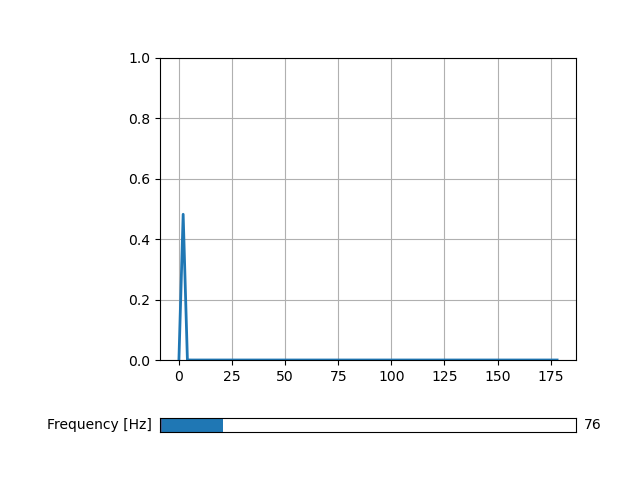

In [302]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button




P_even2 = prob.T

def f(t,array):
    return array[t]

def update(val):
    line.set_ydata(f(int(freq_slider.val), P_even2))
    fig.canvas.draw_idle()

    
t = 0

#init_frequency = 250

fig, ax = plt.subplots()
line, = plt.plot([i*2 for i in range(len(P_even2[t]))], f(t, P_even2), lw=2)

ax.set_ylim(0,1)
plt.grid()

axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])


freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0,
    valmax=500,
    valfmt = "%d",
    valinit=t,
)

plt.subplots_adjust(left=0.25, bottom=0.25)

freq_slider.on_changed(update)
plt.show()